**Hillstrom Dataset**

An email marketing dataset from Kevin Hillstrom's MineThatData blog.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Exploration-Data" data-toc-modified-id="Exploration-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exploration Data</a></span></li><li><span><a href="#Modeling-Data" data-toc-modified-id="Modeling-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modeling Data</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Full-Data-Visualization" data-toc-modified-id="Full-Data-Visualization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Full Data Visualization</a></span></li><li><span><a href="#Modeling-Data-Preparation" data-toc-modified-id="Modeling-Data-Preparation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modeling Data Preparation</a></span></li></ul></li><li><span><a href="#Standard-Models" data-toc-modified-id="Standard-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standard Models</a></span><ul class="toc-item"><li><span><a href="#Two-Model" data-toc-modified-id="Two-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Two Model</a></span></li><li><span><a href="#Interaction-Term" data-toc-modified-id="Interaction-Term-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Interaction Term</a></span></li><li><span><a href="#Class-Transformations" data-toc-modified-id="Class-Transformations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Class Transformations</a></span><ul class="toc-item"><li><span><a href="#Binary-Transformation" data-toc-modified-id="Binary-Transformation-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Binary Transformation</a></span></li><li><span><a href="#Quaternary-Transformation" data-toc-modified-id="Quaternary-Transformation-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Quaternary Transformation</a></span></li></ul></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Iterations" data-toc-modified-id="Iterations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Iterations</a></span></li><li><span><a href="#Visual" data-toc-modified-id="Visual-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visual</a></span></li><li><span><a href="#Iterated-Evaluation-and-Variance" data-toc-modified-id="Iterated-Evaluation-and-Variance-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Iterated Evaluation and Variance</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from causeinfer.data import hillstrom
from causeinfer.utils import plot_unit_distributions, train_test_split, over_sample
from causeinfer.utils import mutli_cross_tab
from causeinfer.standard_algorithms import TwoModel, InteractionTerm
from causeinfer.standard_algorithms import BinaryTransformation
from causeinfer.standard_algorithms import QuaternaryTransformation
from causeinfer.evaluation import qini_score, auuc_score
from causeinfer.evaluation import plot_cum_effect, plot_cum_gain, plot_qini
from causeinfer.evaluation import plot_batch_responses, signal_to_noise
from causeinfer.evaluation import iterate_model, eval_table

pd.set_option("display.max_rows", 16)
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# Load Data

In [2]:
hillstrom.download_hillstrom()

The dataset already exists at /Users/andrewmcallister/Documents/learning/programming/causeinfer/examples/datasets/hillstrom.csv


## Exploration Data

In [3]:
# The full mostly unformatted dataset is loaded
data_raw = hillstrom.load_hillstrom(user_file_path="datasets/hillstrom.csv",
                                    format_covariates=False, 
                                    normalize=False)

df_full = pd.DataFrame(data_raw["dataset_full"], 
                       columns=data_raw["dataset_full_names"])

display(df_full.head())
df_full.shape

,treatment,recency,history_segment,history,mens,womens,zip_code,newbie,channel,conversion,visit,spend
0,Womens E-Mail,10,100_200,142.44,1,0,Surburban,0,Phone,0,0,0
1,No E-Mail,6,200_350,329.08,1,1,Rural,1,Web,0,0,0
2,Womens E-Mail,7,100_200,180.65,0,1,Surburban,1,Web,0,0,0
3,Mens E-Mail,9,500_750,675.83,1,0,Rural,1,Web,0,0,0
4,Womens E-Mail,2,0_100,45.34,1,0,Urban,0,Web,0,0,0


(64000, 12)

## Modeling Data

In [4]:
# The formatted dataset is loaded
data_hillstrom = hillstrom.load_hillstrom(user_file_path="datasets/hillstrom.csv",
                                          format_covariates=True, 
                                          normalize=True)

df = pd.DataFrame(data_hillstrom["dataset_full"], 
                  columns=data_hillstrom["dataset_full_names"])
display(df.head())
df.shape

,treatment,recency,history,mens,womens,newbie,zip_code_rural,zip_code_surburban,zip_code_urban,history_segment_0_100,history_segment_1000+,history_segment_100_200,history_segment_200_350,history_segment_350_500,history_segment_500_750,history_segment_750_1000,channel_multichannel,channel_phone,spend,conversion,visit,channel_web
0,2.0,1.207742,-0.389000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.067358,0.339611,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.0,0.352454,-0.239834,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.922646,1.693265,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,-1.073025,-0.768062,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(64000, 22)

In [5]:
# Covariates, treatments and responses are loaded separately
X = data_hillstrom["features"]

y = data_hillstrom["response_visit"] # response_visit, response_spend or response_conversion

# 1 is men's campaign, 2 is women's, and 0 is control
w = data_hillstrom["treatment"]

# Data Exploration

In [6]:
sns.set(style="whitegrid")

## Full Data Visualization

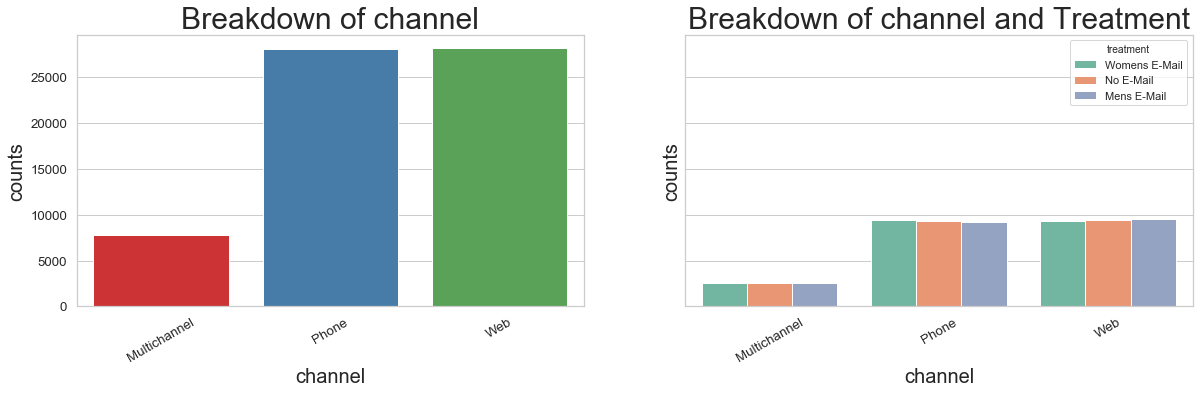

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

plot_unit_distributions(df=df_full, variable='channel', treatment = None,
                        plot_x_label='channel', plot_y_label='counts', plot_title='Breakdown of channel', 
                        bins=None, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='channel', treatment = 'treatment',
                        plot_x_label='channel', plot_y_label='counts', plot_title='Breakdown of channel and Treatment', 
                        bins=None, figsize=None, fontsize=20, axis=ax2)

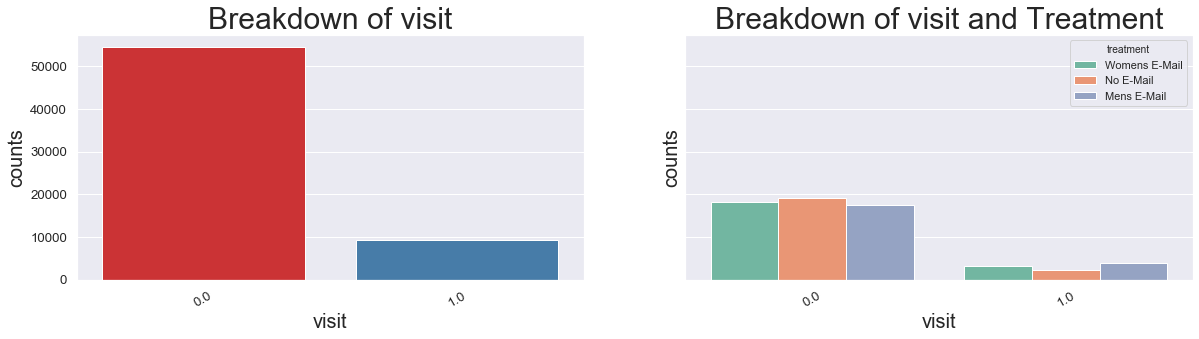

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))
fig.subplots_adjust(bottom=0.2) # Add space after plots

plot_unit_distributions(df=df_full, variable='visit', treatment = None,
                        plot_x_label='visit', plot_y_label='counts', plot_title='Breakdown of visit', 
                        bins=None, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='visit', treatment = 'treatment',
                        plot_x_label='visit', plot_y_label='counts', plot_title='Breakdown of visit and Treatment', 
                        bins=None, figsize=None, fontsize=20, axis=ax2)
plt.savefig('outputs_images/hillstrom_breakdown_visit.png', dpi=150)

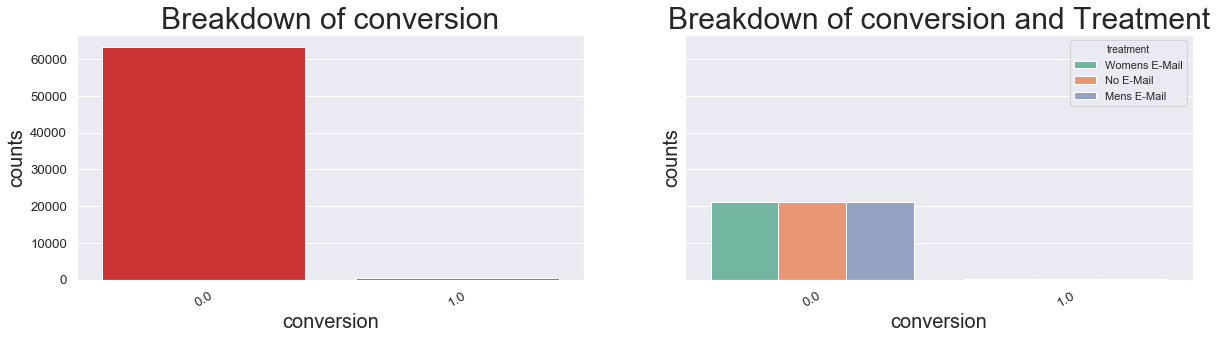

In [72]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))
fig.subplots_adjust(bottom=0.2) # Add space after plots

plot_unit_distributions(df=df_full, variable='conversion', treatment = None,
                        plot_x_label='conversion', plot_y_label='counts', plot_title='Breakdown of conversion', 
                        bins=None, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='conversion', treatment = 'treatment',
                        plot_x_label='conversion', plot_y_label='counts', plot_title='Breakdown of conversion and Treatment', 
                        bins=None, figsize=None, fontsize=20, axis=ax2)
plt.savefig('outputs_images/hillstrom_breakdown_conversion.png', dpi=150)

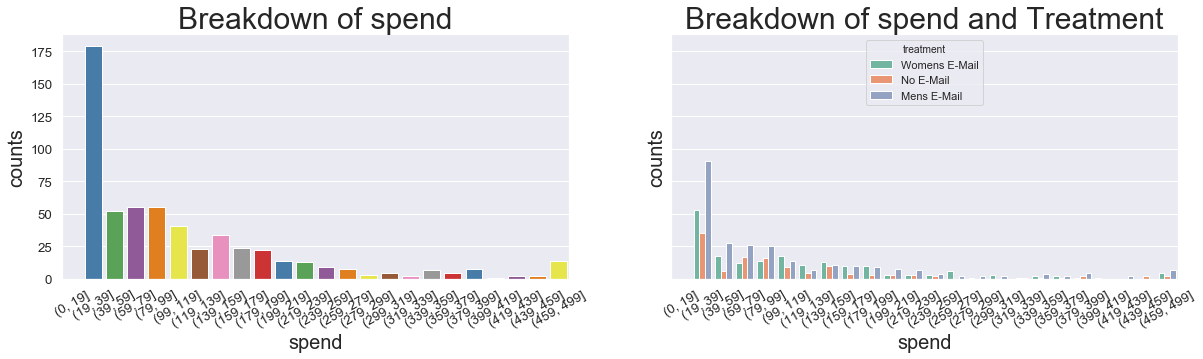

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))
fig.subplots_adjust(bottom=0.2) # Add space after plots

plot_unit_distributions(df=df_full, variable='spend', treatment = None,
                        plot_x_label='spend', plot_y_label='counts', plot_title='Breakdown of spend', 
                        bins=25, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='spend', treatment = 'treatment',
                        plot_x_label='spend', plot_y_label='counts', plot_title='Breakdown of spend and Treatment', 
                        bins=25, figsize=None, fontsize=20, axis=ax2)
plt.savefig('outputs_images/hillstrom_breakdown_spend.png', dpi=150)

If the target was spend, then we'd want to focus on the men's campaign, but for visit using the more often used women's campaign is reasonable.

In [11]:
mutli_cross_tab(df=df, w_col='treatment', y_cols = ['visit', 'conversion'], 
                            label_limit=6, margins=True, normalize=True)

,visit_0.0,visit_1.0,conver_0.0,conver_1.0,All
treatment,,,,,
0.0,0.297563,0.035344,0.331000,0.001906,0.332906
1.0,0.272078,0.060844,0.328750,0.004172,0.332922
2.0,0.283578,0.050594,0.331219,0.002953,0.334172
All,0.853219,0.146781,0.990969,0.009031,1.000000


In [12]:
# 0=control, 1=mens, 2=women's
df.pivot_table(values=['visit', 'conversion', 'spend'],
               index='treatment',
               aggfunc=[np.mean],
               margins=True)

mean                    
          conversion     spend     visit
treatment                               
0.0         0.005726  0.652789  0.106167
1.0         0.012531  1.422617  0.182757
2.0         0.008837  1.077202  0.151400
All         0.009031  1.050908  0.146781

## Modeling Data Preparation

In [13]:
# Counts for treatment
control_indexes = [i for i, e in enumerate(w) if e == 0]
mens_indexes = [i for i, e in enumerate(w) if e == 1]
womens_indexes = [i for i, e in enumerate(w) if e == 2]

womens_mens_indexes = womens_indexes + mens_indexes

print(len(control_indexes))
print(len(mens_indexes))
print(len(womens_indexes))
print(len(womens_mens_indexes))

21306
21307
21387
42694


In [14]:
X_control = X[control_indexes]
y_control = y[control_indexes]
w_control = w[control_indexes]

X_women = X[womens_indexes]
y_women = y[womens_indexes]
w_women = w[womens_indexes]

In [15]:
# Change 2s to 1s in women's campaign
w_women = [1 for i in w_women if i == 2]
w_women[:5]

[1, 1, 1, 1, 1]

In [16]:
# Over-sampling of control
X_os, y_os, w_os = over_sample(X_1=X_control, y_1=y_control, w_1=w_control, 
                               sample_2_size=len(X_women), shuffle=True)


    Old Covariates shape  : (21306, 18)
    Old responses shape   : (21306,)
    Old treatments shape  : (21306,)
    New covariates shape  : (21387, 18)
    New responses shape   : (21387,)
    New treatments shape  : (21387,)
    Matched sample length :  21387
                        


In [17]:
X_split = np.append(X_os, X_women, axis=0)
y_split = np.append(y_os, y_women, axis=0)
w_split = np.append(w_os, w_women, axis=0)

X_split.shape, y_split.shape, w_split.shape # Should all be equal in the first dimension

((42774, 18), (42774,), (42774,))

In [18]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X_split, y_split, w_split, 
                                                                     percent_train=0.7, random_state=42, 
                                                                     maintain_proportions=True)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, w_train.shape, w_test.shape

((29940, 18), (12834, 18), (29940,), (12834,), (29940,), (12834,))

In [20]:
print(np.array(np.unique(y_train, return_counts=True)).T)
print(np.array(np.unique(y_test, return_counts=True)).T)

[[    0 26128]
 [    1  3812]]
[[    0 11137]
 [    1  1697]]


In [21]:
print(np.array(np.unique(w_train, return_counts=True)).T)
print(np.array(np.unique(w_test, return_counts=True)).T)

[[    0 14970]
 [    1 14970]]
[[   0 6417]
 [   1 6417]]


In [22]:
sn_ratio = signal_to_noise(y=y_split, w=w_split)
sn_ratio

0.42580361074416556

The signal to noise ratio suggests at a base level that there is a benefit to using CI with this dataset.

# Standard Models

The following cells present single iteration modeling, with analysis being done over multiple iterations.

## Two Model

In [23]:
tm = TwoModel(treatment_model=RandomForestClassifier(),
              control_model=RandomForestClassifier())
tm.fit(X=X_train, y=y_train, w=w_train)

In [24]:
tm_probas = tm.predict_proba(X=X_test)
tm_probas[:5]

array([[0.92      , 0.98      ],
       [0.99625   , 0.84888179],
       [0.93      , 0.38      ],
       [0.27      , 1.        ],
       [0.95      , 0.87      ]])

## Interaction Term

In [25]:
it = InteractionTerm(model=RandomForestClassifier())
it.fit(X=X_train, y=y_train, w=w_train)

In [26]:
it_probas = it.predict_proba(X=X_test)
it_probas[:5]

array([[0.91     , 0.99     ],
       [1.       , 0.8319916],
       [0.89     , 0.27     ],
       [0.29     , 1.       ],
       [0.94     , 0.89     ]])

## Class Transformations

### Binary Transformation

In [27]:
bt = BinaryTransformation(model=RandomForestClassifier(), regularize=False)
bt.fit(X=X_train, y=y_train, w=w_train)

In [28]:
bt_probas = bt.predict_proba(X=X_test)
bt_probas[:5]

array([[0.88      , 0.12      ],
       [0.62539422, 0.37460578],
       [0.07      , 0.93      ],
       [0.98      , 0.02      ],
       [0.25      , 0.75      ]])

### Quaternary Transformation

In [29]:
qt = QuaternaryTransformation(model=RandomForestClassifier(), regularize=False)
qt.fit(X=X_train, y=y_train, w=w_train)

In [30]:
qt_probas = qt.predict_proba(X=X_test)
qt_probas[:5]

array([[0.98      , 0.02      ],
       [0.60604218, 0.39395782],
       [0.16      , 0.84      ],
       [1.        , 0.        ],
       [0.24      , 0.76      ]])

# Evaluation

## Iterations

In [44]:
# New models instatiated with a more expansive scikit-learn base model (assign individually)
tm = TwoModel(treatment_model=RandomForestClassifier(n_estimators=200, 
                                                     criterion='gini', 
                                                     bootstrap=True),
              control_model=RandomForestClassifier(n_estimators=200, 
                                                   criterion='gini', 
                                                   bootstrap=True))

it = InteractionTerm(model=RandomForestClassifier(n_estimators=200, 
                                                  criterion='gini', 
                                                  bootstrap=True))

bt = BinaryTransformation(model=RandomForestClassifier(n_estimators=200, 
                                                       criterion='gini', 
                                                       bootstrap=True), regularize=False)

qt = QuaternaryTransformation(model=RandomForestClassifier(n_estimators=200, 
                                                           criterion='gini', 
                                                           bootstrap=True), regularize=False)

In [46]:
n=200
model_eval_dict = {}
model_eval_dict['Hillstrom'] = {}
model_eval_dict

{'Hillstrom': {}}

In [47]:
for dataset in model_eval_dict.keys():
    for model in [tm, it, bt, qt]: #grf
        avg_preds, all_preds, \
        avg_eval, eval_variance, \
        eval_sd, all_evals = iterate_model(model=model, X_train=X_train, y_train=y_train, w_train=w_train,
                                           X_test=X_test, y_test=y_test, w_test=w_test, tau_test=None, n=n,
                                           pred_type='predict_proba', eval_type='qini', 
                                           normalize_eval=False, notify_iter=n/10)
        model_eval_dict[dataset].update({str(model).split('.')[-1].split(' ')[0]: {'avg_preds': avg_preds, 'all_preds': all_preds, 
                                                                                   'avg_eval': avg_eval, 'eval_variance': eval_variance,
                                                                                   'eval_sd': eval_sd, 'all_evals': all_evals}})

Starting TwoModel iterations
10.0 percent of iterations have finished
20.0 percent of iterations have finished
30.0 percent of iterations have finished
40.0 percent of iterations have finished
50.0 percent of iterations have finished
60.0 percent of iterations have finished
70.0 percent of iterations have finished
80.0 percent of iterations have finished
90.0 percent of iterations have finished
100.0 percent of iterations have finished
-----
Starting InteractionTerm iterations
10.0 percent of iterations have finished
20.0 percent of iterations have finished
30.0 percent of iterations have finished
40.0 percent of iterations have finished
50.0 percent of iterations have finished
60.0 percent of iterations have finished
70.0 percent of iterations have finished
80.0 percent of iterations have finished
90.0 percent of iterations have finished
100.0 percent of iterations have finished
-----
Starting BinaryTransformation iterations
10.0 percent of iterations have finished
20.0 percent of ite

In [48]:
# Treatment and control probability subtraction
tm_effects = [pred[0] - pred[1] \
              for pred in model_eval_dict['Hillstrom']['TwoModel']['avg_preds']]

# Treatment interaction and control interaction probability subtraction
it_effects = [pred[0] - pred[1] \
              for pred in model_eval_dict['Hillstrom']['InteractionTerm']['avg_preds']]

# Bianry favorable and unfavorable class probability subtraction
bt_effects = [pred[0] - pred[1] \
              for pred in model_eval_dict['Hillstrom']['BinaryTransformation']['avg_preds']]

# Quaternary favorable and unfavorable class probability subtraction
qt_effects = [pred[0] - pred[1] \
              for pred in model_eval_dict['Hillstrom']['QuaternaryTransformation']['avg_preds']]

## Visual

In [49]:
visual_eval_dict = {'y_test': y_test, 'w_test': w_test, 
                    'two_model': tm_effects, 'interaction_term': it_effects, 
                    'binary_trans': bt_effects, 'quaternary_trans': qt_effects}

In [50]:
df_visual_eval = pd.DataFrame(visual_eval_dict, columns = visual_eval_dict.keys())

display(df_visual_eval.head())
df_visual_eval.shape

,y_test,w_test,two_model,interaction_term,binary_trans,quaternary_trans
0,0,0,-0.073475,-0.085450,0.803950,0.821500
1,0,0,0.177693,0.178225,0.200118,0.200078
2,0,0,0.591275,0.582400,-0.825900,-0.815650
3,0,1,-0.692098,-0.690399,0.983840,0.986050
4,0,0,0.063650,0.074100,-0.517550,-0.482700


(12834, 6)

In [51]:
models = [col for col in visual_eval_dict.keys() if col not in ['y_test', 'w_test']]

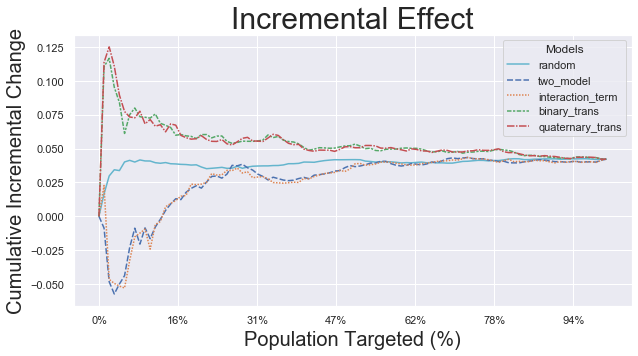

In [75]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20,5))

plot_cum_effect(df=df_visual_eval, n=100, models=models, percent_of_pop=True, 
                outcome_col='y_test', treatment_col='w_test', random_seed=42, 
                figsize=(10,5), fontsize=20, axis=None, legend_metrics=False)

# plot_batch_responses(df=df_visual_eval, n=10, models=models, 
#                      outcome_col='y_test', treatment_col='w_test', normalize=False,
#                      figsize=None, fontsize=15, axis=ax2)
plt.savefig('outputs_images/hillstrom_cum_effect.png', dpi=150)

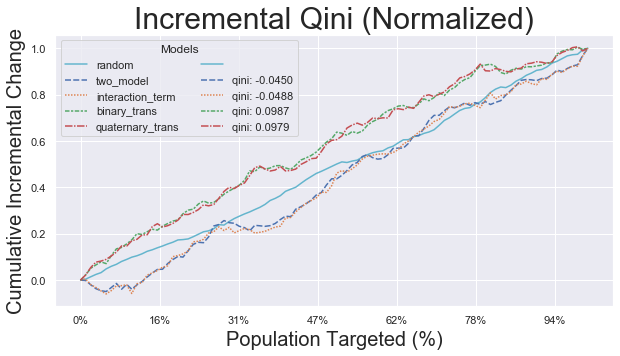

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20,5))

plot_cum_gain(df=df_visual_eval, n=100, models=models, percent_of_pop=True,
              outcome_col='y_test', treatment_col='w_test', normalize=True, random_seed=42, 
              figsize=None, fontsize=20, axis=ax1, legend_metrics=True)

plot_qini(df=df_visual_eval, n=100, models=models, percent_of_pop=True, 
          outcome_col='y_test', treatment_col='w_test', normalize=True, random_seed=42, 
          figsize=None, fontsize=20, axis=ax2, legend_metrics=True)
plt.savefig('outputs_images/hillstrom_qini.png', dpi=150)

## Iterated Evaluation and Variance

In [54]:
# Qini
df_model_eval = eval_table(model_eval_dict, variances=True, annotate_vars=True)

df_model_eval

,TwoModel,InteractionTerm,BinaryTransformation,QuaternaryTransformation
Hillstrom,-11.3679 ± 4.1815**,-12.0572 ± 3.8969*,26.4654 ± 1.4038*,26.2114 ± 1.2957*


# Summary